# Imports


In [ ]:
import numpy as np
import pandas as pd

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import nltk.downloader
import string
import re

from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

from scipy import linalg
from scipy import sparse

# NLTK PREP


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Text import and Cleaning


In [ ]:
data = pd.read_csv('/content/sport_garden.csv', header=0)['Description']

data = [d for d in data if len(d.split(" ")) >=30]

clean_data = []
for text in data:
  text = text.lower()
  text = re.sub(r'http\S+','',text,)
  text = "".join([char for char in text if char in string.ascii_lowercase+' '+string.digits])
  text = text.split(" ")
  text = [word for word in text if  word not in stop_words]
  text = [lemmatizer.lemmatize(word) for word in text]
  clean_text = "".join([str(word)+" " for word in text])[:-2]
  clean_data.append(clean_text)

# Build and Train Doc2Vec


In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(clean_data)]

In [ ]:
max_epochs = 100
vec_size = 30
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                window = 10,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [ ]:
model= Doc2Vec.load("d2v.model")

In [ ]:
matrix = []
for i in range(len(model.docvecs)):
  matrix.append(model.docvecs[i])

matrix = sparse.coo_matrix(matrix)

# Train K-means


In [ ]:
inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(matrix)
    inertias.append(k_means.inertia_)

In [ ]:
biggest = 0
big_index = 0
for i , _ in enumerate(inertias[1:]):

    diff = (inertias[i-1] - inertias[i])
    if  diff > biggest:
      biggest = diff
      big_index = i-1

num_clusters = big_index +2

In [ ]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=45, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster , k_means

In [ ]:
cluster , k_means = run_k_means(matrix, n_clusters= 2)

In [ ]:
len([text.split(" ") for text in clean_data])
len(cluster)

1910

# Build Results Dataframe

In [ ]:
d = {'Text':clean_data,'Label': cluster, "Words": [text.split(" ") for text in clean_data]}
results = pd.DataFrame(d)
results

,Text,Label,Words
0,without annoying gas line spray paint use seri...,1,"[without, annoying, gas, line, spray, paint, u..."
1,sadly theyre taught mark really well even take...,0,"[sadly, theyre, taught, mark, really, well, ev..."
2,lot attention daily automate watering thats re...,0,"[lot, attention, daily, automate, watering, th..."
3,use plain cardboard box weed barrier amp work ...,1,"[use, plain, cardboard, box, weed, barrier, am..."
4,lasagna gardening thing look little janky mulc...,0,"[lasagna, gardening, thing, look, little, jank..."
...,...,...,...
1905,agree people change drastically span year yes ...,1,"[agree, people, change, drastically, span, yea..."
1906,agree first half arizona dropped anybody pick ...,1,"[agree, first, half, arizona, dropped, anybody..."
1907,totally 100 agree guess im saying think went u...,1,"[totally, 100, agree, guess, im, saying, think..."
1908,imagine would happened public reacted strongly...,1,"[imagine, would, happened, public, reacted, st..."


In [ ]:
n = 0
for text in results['Text']:
    if n < 10:
      print(text)
      print('\n')
      n = n + 1

without annoying gas line spray paint use seriously cant mark something little appealing theyll spray right pavers everything


sadly theyre taught mark really well even take photo mark afterward proof people dig hit gas power line try claim wasnt marked properly leading lawsuit source worked locator boring job


lot attention daily automate watering thats rest kinda piecemeal thing established bad spent first year pulling new weed flower bed every weekend year much also help devote 10 minute every day weed pulling


use plain cardboard box weed barrier amp work quite well allowing earth breathe properly  also yeahits fuckton work said get little high first insanely relaxing


lasagna gardening thing look little janky mulched looked good bermuda grass beast snaked layer popped resilient admire bermuda grass


earthworm invasive specie many place please dont introduce area native earthworm population catch release nearby area otherwise stick form soil improvement


yes ive moved 1910 ho

# Build Word Clouds

In [ ]:
num_clusters = 2 

topics = [0]*num_clusters

for  i in range(num_clusters):

  topic = results.loc[results['Label'] == i]

  topic_count = {}

  for words in topic["Words"]:

    for word in words:

      if word in topic_count:

        topic_count[word] = topic_count[word] + 1
      
      else:

        topic_count[word] = 1
  
  topics[i] = topic_count

In [ ]:
topic_words = [0]*num_clusters

for i in  range(num_clusters):

  not_words = []
  not_index = list(range(0,num_clusters, 1))
  not_index.remove(i)

  for index in not_index:

    for word in topics[index].keys():
      not_words.append(word)

  words = [word for word in topics[i].keys() if word not in not_words]

  max_freq = [[0,0]] * 20

  for key in words:

    max_freq = sorted(max_freq)
    min_freq = max_freq[0][0]
    if topics[i][key] > min_freq:
      max_freq[0] = [topics[i][key] ,key]

  topic_words[i] = max_freq


topic_words


[[[12, 'flowering'],
  [12, 'overwinter'],
  [12, 'watering'],
  [13, 'crocus'],
  [13, 'ordinance'],
  [14, 'rain'],
  [14, 'veggie'],
  [15, 'dug'],
  [15, 'farm'],
  [16, 'meyer'],
  [19, 'organic'],
  [20, 'sauce'],
  [24, 'fertilizer'],
  [24, 'variety'],
  [27, 'harvest'],
  [33, 'fruit'],
  [55, 'lemon'],
  [61, 'tulip'],
  [93, 'grow'],
  [104, 'flower']],
 [[16, 'active'],
  [16, 'disability'],
  [17, 'assault'],
  [18, 'dana'],
  [18, 'discus'],
  [19, 'bully'],
  [20, 'biden'],
  [20, 'dumb'],
  [21, 'join'],
  [21, 'oz'],
  [21, 'protest'],
  [22, 'hockey'],
  [22, 'race'],
  [23, 'government'],
  [26, 'league'],
  [27, 'discord'],
  [27, 'server'],
  [30, 'situation'],
  [31, 'win'],
  [42, 'tyson']]]

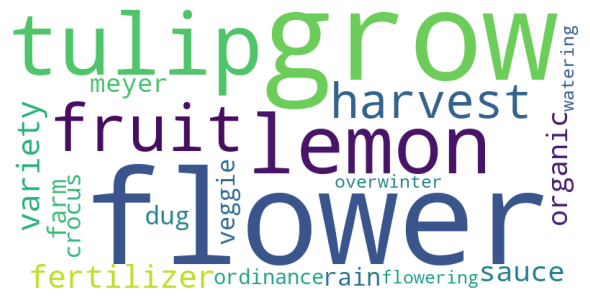

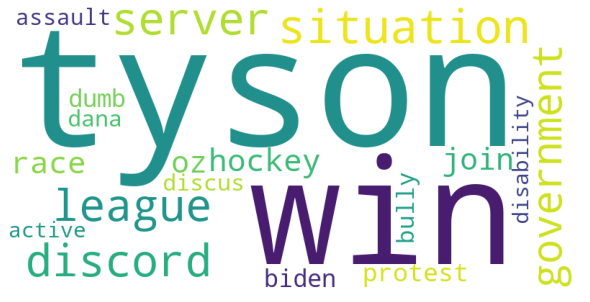

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

for i in range(len(topic_words)):
  cloud = {} 
  for  value , key in topic_words[i]:
    cloud[key] = value

  wc = WordCloud(width=800, height=400, max_words=20, background_color= 'white').generate_from_frequencies(cloud)
    
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
    
  plt.show() 

  print("\n")

# Make New Predictions

In [ ]:
def cleanText(text):

  text = text.lower()
  text = re.sub(r'http\S+','',text,)
  text = "".join([char for char in text if char in string.ascii_lowercase+' '+string.digits])
  text = text.split(" ")
  text = [word for word in text if  word not in stop_words]
  text = [lemmatizer.lemmatize(word) for word in text]

  return text

In [ ]:
k_means.cluster_centers_

In [ ]:
test = "Gardening is the practice of growing and cultivating plants as part of horticulture. In gardens, ornamental plants are often grown for their flowers, foliage, or overall appearance; useful plants, such as root vegetables, leaf vegetables, fruits, and herbs, are grown for consumption, for use as dyes, or for medicinal or cosmetic use. Gardening is considered by many people to be a relaxing activity."
test = cleanText(test)
test_vector = model.infer_vector(test, epochs = 100).reshape(1,-1)
prediction = k_means.predict(test_vector)
prediction